In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import umap

from sklearn.ensemble import RandomForestClassifier

In [2]:
import hail as hl
hl.init()

Loading BokehJS ...

24/06/14 14:43:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.4
SparkUI available at http://192.168.0.16:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.130-bea04d9c79b5
LOGGING: writing to /Users/benoppenheimer/Dropbox (Partners HealthCare)/ancestry_analysis_2/code/hail-20240614-1443-0.2.130-bea04d9c79b5.log


In [3]:
scores_ht = hl.read_table("../scores.ht")
scores_df = scores_ht.to_pandas()
scores_df = scores_df.set_index("s")
scores_df.head()

,continental_ancestry,subcontinental_ancestry,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
s,,,,,,,,,,,,
CW-170-S,sample,sample,-0.168061,0.053011,-0.003688,-0.064679,0.160545,0.018122,-0.167285,0.036319,0.004731,-0.005015
CW-179-S,sample,sample,-0.197754,0.029243,-0.05437,-0.012802,-0.078045,0.000179,-0.007065,0.015459,0.001916,-0.015361
CW117-S,sample,sample,-0.176428,0.037183,0.005524,-0.073567,0.166499,0.031693,-0.162439,0.02076,-0.002445,0.036797
CW12S,sample,sample,-0.18254,0.040677,-0.00888,-0.060091,0.149823,0.028132,-0.127282,0.003136,-0.026386,0.008141
CW140-G,sample,sample,-0.177081,0.043861,-0.004675,-0.031609,0.067403,-0.01372,0.057719,-0.000907,0.009152,0.006214


In [4]:
ref_samples_pca = scores_df[scores_df.continental_ancestry != "sample"]
our_samples_pca = scores_df[scores_df.continental_ancestry == "sample"].iloc[:, 2:]

X = ref_samples_pca.iloc[:, 2:]
y = ref_samples_pca.continental_ancestry

ancestry_assignment = pd.DataFrame(index = our_samples_pca.index, columns = range(100))

np.random.seed(18)
rand_nums = np.random.randint(low=0, high=1000, size=100)

i = 0
for rand_num in tqdm(rand_nums):

    clf = RandomForestClassifier(random_state=rand_num)
    clf.fit(X, y)

    predictions = clf.predict(our_samples_pca)

    ancestry_assignment.loc[:, i] = predictions

    i += 1

ancestry_assignment.head()

100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
s,,,,,,,,,,,,,,,,,,,,,
CW-170-S,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,...,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR
CW-179-S,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,...,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR
CW117-S,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,...,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR
CW12S,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,...,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR
CW140-G,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,...,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR


In [5]:
final_assignments = ancestry_assignment.mode(axis=1)
final_assignments.head()

,0
s,
CW-170-S,EUR
CW-179-S,EUR
CW117-S,EUR
CW12S,EUR
CW140-G,EUR


In [6]:
final_assignments.value_counts()

0  
EUR    322
MID      8
AMR      2
AFR      1
CSA      1
Name: count, dtype: int64

In [8]:
final_assignments[final_assignments.values != "EUR"].to_csv("../non_euro_samples.txt",
                                                            index=False, header=False)

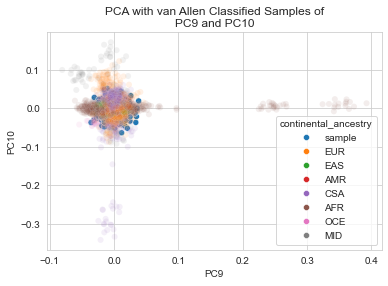

In [30]:
ancestries = scores_df.continental_ancestry.unique()

for i in range(0, 9):
    pc1 = f"PC{str(i + 1)}"
    pc2 = f"PC{str(i + 2)}"

    filename = f"../kg_hgdp_asj_pca_results/{pc1}_and_{pc2}.png"

    plt.clf()

    sns.scatterplot(scores_df.loc[our_samples_pca.index], x=pc1, y=pc2,
                    hue="continental_ancestry", hue_order=ancestries)
    sns.scatterplot(ref_samples_pca, x=pc1, y=pc2,
                    hue="continental_ancestry", hue_order=ancestries, alpha=0.1,
                    legend=False)

    plt.title(f"PCA with van Allen Classified Samples of\n{pc1} and {pc2}")

    plt.savefig(filename)

In [34]:
scores_df.to_csv("../scores.tsv", sep="\t")

In [36]:
reducer = umap.UMAP()

cols_to_drop = ["continental_ancestry", "subcontinental_ancestry"]
embedding = reducer.fit_transform(scores_df.drop(columns=cols_to_drop))

embedding.shape

NameError: name 'umap' is not defined